# End to End Project - Bikes Assessment

Task: The dataset (Location: ) contains the hourly rental bike demand data. The goal is to develop a model to estimate the bike demand in future given the parameters as observed in the past.

We will be following this example step-by-step in this assessment:
1. Importing the libraries
1. Defining some utility functions
1. Loading the data
1. Cleaning the data
1. Adding derived features
1. Analyzing the dataset
1. Dividing the dataset into training and test dataset
1. Training several models and analyzing their performance
1. Selecting a model and evaluating using test dataset
1. Improving the model by finding the best hyper-parameters and features
1. Analyzing the residuals

### Importing the libraries
We will import these libraries into the environment

1. **numpy:** np
1. **pandas:** pd
1. **sklearn** - preprocessing, linear_model, StandardScaler, mean_squared_error
1. **matplotplib.pyplot:** plt
1. **os**

Please complete the code to import these libraries.

In [2]:
import pandas as pd
import numpy as np

## Task: import os
import os
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

### Some utility functions

In [3]:
def set_day(df):
    '''
    This function assigns day names to each of the
    rows in the dataset. 
    '''
    ## Assumes the first day of the dataset is Saturday
    days = ["Sat", "Sun", "Mon", "Tue", "Wed", "Thr", "Fri"]
    temp = ['d']*df.shape[0]
    i = 0
    indx = 0
    cur_day = df.weekday[0]
    for day in df.weekday:
        temp[indx] = days[(day-cur_day+7)%7]
        indx += 1
    df['dayWeek'] = temp
    return df

# Function that takes in a dataframe with yr and mnth attribute and calculates an array denoting the month number from the start
def mnth_cnt(df):
    '''
    Compute the count of months from the start of
    the time series.
    '''
    import itertools
    yr = df['yr'].tolist()
    mnth = df['mnth'].tolist()
    out = [0] * df.shape[0]
    indx = 0
    for x, y in zip(mnth, yr):
        out[indx] = x + 12 * y
        indx += 1
    return out


# Function used to calculate the basics stats of observed scores from cross-validation of models
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

### Loading the data

The dataset can be loaded from a csv which is present on the shared drive at the location: 
(Location: )

The dataset contains the following parameters:
* instant: record index
* dteday : date
* season : season (1:springer, 2:summer, 3:fall, 4:winter)
* yr : year (0: 2011, 1:2012)
* mnth : month ( 1 to 12)
* hr : hour (0 to 23)
* holiday : weather day is holiday or not (extracted from [Web Link])
* weekday : day of the week
* workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp : Normalized temperature in Celsius. The values are derived via (t*t_min)/(t_max*t_min), t_min=*8, t_max=+39 (only in hourly scale)
* atemp: Normalized feeling temperature in Celsius. The values are derived via (t*t_min)/(t_max*t_min), t_min=*16, t_max=+50 (only in hourly scale)
* hum: Normalized humidity. The values are divided to 100 (max)
* windspeed: Normalized wind speed. The values are divided to 67 (max)
* casual: count of casual users
* registered: count of registered users
* cnt: count of total rental bikes including both casual and registered

**Task:** Please complete the read statement correctly. 

In [38]:
filePath = 'datasets\\bikes\\bikes.csv'

## Task: Complete the statement below
bikesData = pd.read_csv(filePath)

print(bikesData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB
None


In [5]:
len(bikesData)

17379

### Data cleaning

As we observe, some of the attributes are not required as per the requirement of the project: ['instant','casual','registered','atemp','dteday']. These can be dropped.

Some of the numerical columns will have to be scaled: ['temp','hum','windspeed']

In [6]:
# Task 1: Update the columnsToDrop variable in the order given
columnsToDrop = ['instant','casual','registered','atemp','dteday']

# Task 2
bikesData = bikesData.drop(columnsToDrop,1)

In [7]:
# Task 3: Update the columnsToScale variable in the order given
columnsToScale = ['temp','hum','windspeed']

scaler = StandardScaler()
# Task 4
bikesData[columnsToScale] = scaler.fit_transform(bikesData[columnsToScale])
bikesData[columnsToScale].describe()

,temp,hum,windspeed
count,1.737900e+04,1.737900e+04,1.737900e+04
mean,3.497212e-16,-4.195150e-16,4.035529e-15
std,1.000029e+00,1.000029e+00,1.000029e+00
min,-2.477205e+00,-3.251166e+00,-1.553889e+00
25%,-8.153035e-01,-7.631431e-01,-6.996886e-01
50%,1.564696e-02,1.436398e-02,3.189880e-02
75%,8.465975e-01,7.918711e-01,5.198962e-01
max,2.612367e+00,1.932215e+00,5.399871e+00


### Adding derived features and transforming the data
These features are derived from the raw set of features:
1. **isWorking:** 1: Is a workingday and not a holiday, 0: Is not a workingday and is a holiday
1. **monthCount:** count of the number of months from the beginning of the dataset
1. **xformHr:** transform by shifting the hours by 5 hrs, if the hours are greater than 5, we subtract 5, else we add 19.
1. **dayCnt:** count of the days from the beginning of the dataset
1. **xformWorkHr:** transforming the hour dataset to make the non-working days to have hours from 25 to 48
1. **cntDeTrended:** De-trended count values

**Task:** Complete the statements for calculating each of the above derived attributes.

In [8]:
# Task
bikesData['isWorking'] = np.where(np.logical_and(bikesData.workingday==1,bikesData.holiday==0),1,0)
bikesData['monthCount'] = mnth_cnt(bikesData)
bikesData['xformHr'] = np.where(bikesData.hr>4,bikesData.hr-5,bikesData.hr+19)
bikesData['dayCount'] = pd.Series(range(bikesData.shape[0]))/24
bikesData['xformWorkHr'] = (1-bikesData.isWorking)*24 + bikesData.xformHr
bikesData = set_day(bikesData)

In [9]:
bikesData.sort_values('dayCount', axis= 0, inplace=True)
nrow = bikesData.shape[0]
X = bikesData.dayCount.values.reshape(nrow,1)
Y = bikesData.cnt
clf = linear_model.LinearRegression()
bike_lm = clf.fit(X, Y)

# Task
bikesData['cntDeTrended'] = bikesData.cnt - bike_lm.predict(X)

### Analyzing and visualizing the dataset

These tasks shall be performed as a part of analyzing and visualizing the dataset:
1. Hourly count of bikes with trend and without trend
1. Correlation matrix between the features and the dependent variable
1. Plotting correlation among selected variables - 'yr','mnth','isWorking','xformWorkHr','dayCount','temp','hum','windspeed','cntDeTrended'
1. Plotting the count pattern with daycount for specific hours
1. Plotting box plot for different attributes: 'hr', 'mnth', 'weathersit', 'isWorking', 'dayWeek', 'xformHr'
1. Plotting scatter matrix for selected attributes: 'temp', 'hum', 'windspeed', 'hr', 'xformHr', 'cntDeTrended'
1. Plotting box plots for 0900 and 1800 hrs working and non-working days
1. Plotting the demand counts for each of the transformed work hours which include working and non-working hours

**Task:** Complete the statement to complete plotting the hourly count with trend and without trend.

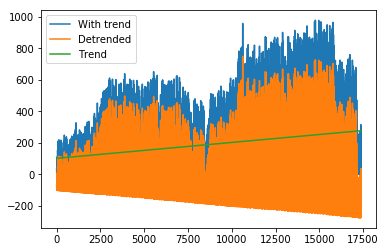

In [10]:
# Task: Complete the statement to complete plotting the hourly count with trend and without trend.
plt.plot(bikesData.loc[:,'cnt'])
plt.plot(bikesData.loc[:,'cntDeTrended'])
plt.plot(bike_lm.predict(X))
plt.legend(['With trend','Detrended','Trend'])
plt.show()

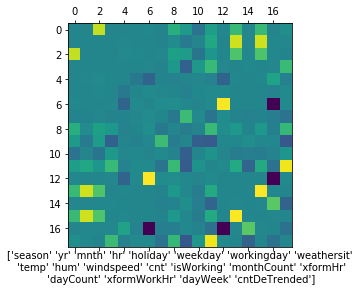

In [11]:
# Ignore
#bikesData.info()
corrMat = bikesData.corr().as_matrix()
np.fill_diagonal(corrMat, 0)
plt.matshow(corrMat)
plt.xlabel(bikesData.columns.values)
plt.show()

#### Correlation Matrix
**Task 1:** Complete the statement to plot the correlation matrix between all the features and the dependent variable.

**Task 2:** Complete the statement to calculate correlation among these variables: 'yr', 'mnth', 'isWorking', 'xformWorkHr', 'dayCount', 'temp', 'hum', 'windspeed', 'cntDeTrended'

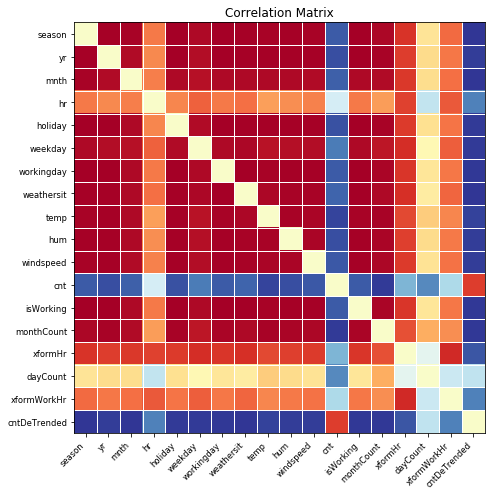

In [12]:
# Task 1: Is there anything missing here?
import statsmodels.graphics.correlation as pltcor
arr = bikesData.drop('dayWeek', axis = 1)
cols = list(arr)
arr = arr.as_matrix()
arr = preprocessing.scale(arr, axis = 1)
corrMat = np.corrcoef(arr, rowvar =0)
np.fill_diagonal(corrMat, 0)
fig = plt.figure(figsize=(7,7))
ax = fig.gca()
pltcor.plot_corr(corrMat, xnames = cols, ax=ax)

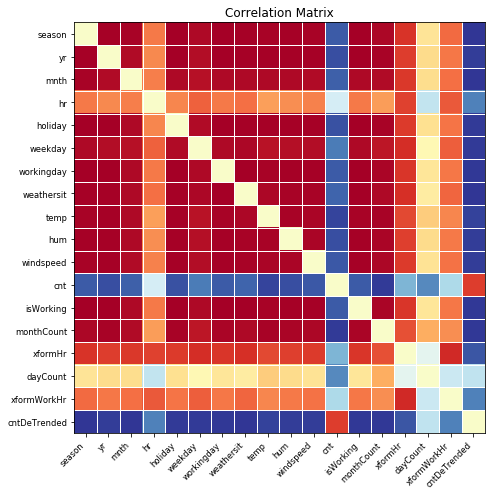

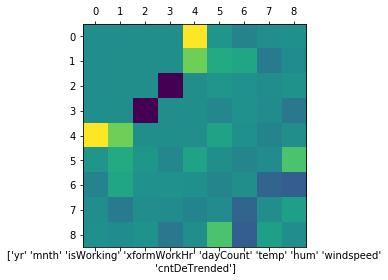

In [13]:
# Ignore
columnToPlotScatter = ['yr','mnth','isWorking','xformWorkHr','dayCount','temp','hum','windspeed','cntDeTrended']
corrMat = bikesData[columnToPlotScatter].corr().as_matrix()
np.fill_diagonal(corrMat, 0)
plt.matshow(corrMat)
plt.xlabel(bikesData[columnToPlotScatter].columns.values)
plt.show()

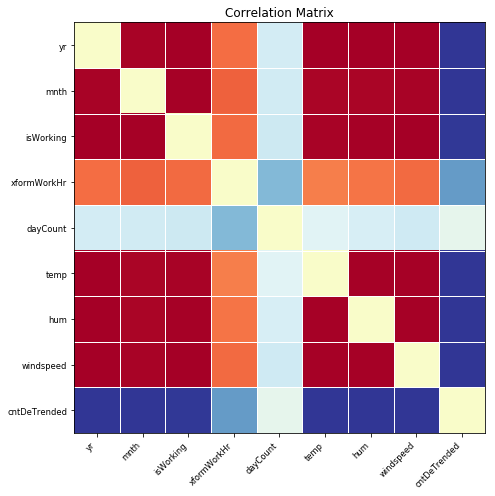

In [14]:
# Task 2
columnToPlotScatter = ['yr','mnth','isWorking','xformWorkHr','dayCount','temp','hum','windspeed','cntDeTrended']

arry = bikesData[columnToPlotScatter].as_matrix()
arry = preprocessing.scale(arry, axis = 1)
corrs = np.corrcoef(arry, rowvar = 0)
np.fill_diagonal(corrs, 0)
col_nms = list(bikesData)[1:]
fig = plt.figure(figsize = (7,7))
ax = fig.gca()
pltcor.plot_corr(corrs, xnames = columnToPlotScatter, ax = ax)
plt.show()

#### Line Plots

**Task 1:** Complete the code to plot cntDeTrended versus dayCount for these hours: [7, 9, 12, 15, 18, 20, 22]

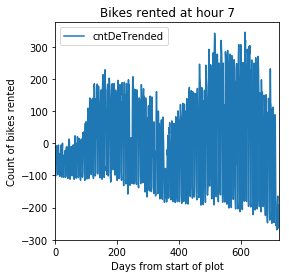

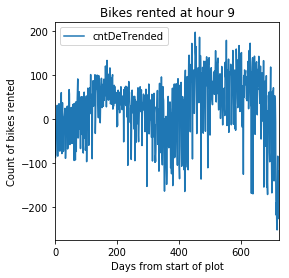

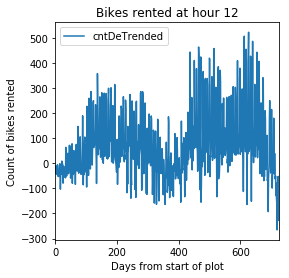

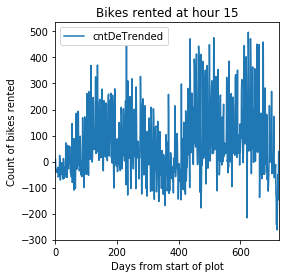

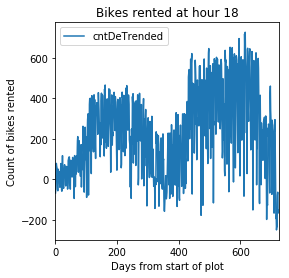

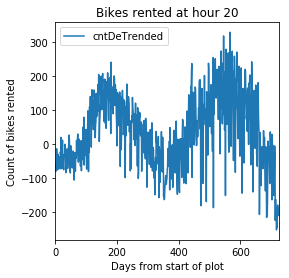

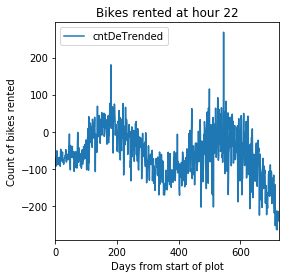

In [15]:
# Task 1: Complete the times variable
times = [7, 9, 12, 15, 18, 20, 22]
for time in times:
    fig = plt.figure(figsize=(4,4))
    tsToPlot = bikesData[bikesData.hr==time]
    fig.clf()
    ax = fig.gca()
    tsToPlot.plot(kind='line', x='dayCount', y='cntDeTrended', ax =ax)
    plt.xlabel("Days from start of plot")
    plt.ylabel("Count of bikes rented")
    plt.title("Bikes rented at hour " + str(time))
    plt.show()

#### Box plots

**Task:** Complete the statement to include these box plots and in this order:
['hr', 'mnth', 'weathersit', 'isWorking', 'dayWeek', 'xformHr']

C:\Users\Pratik\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


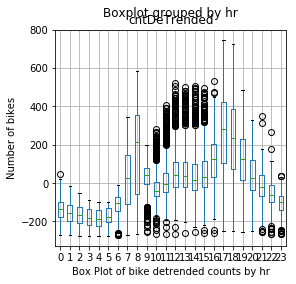

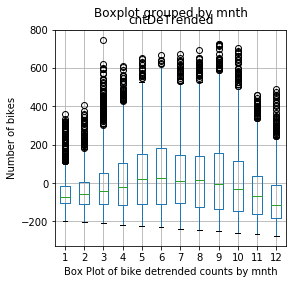

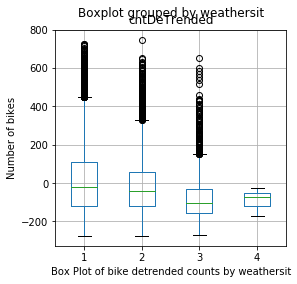

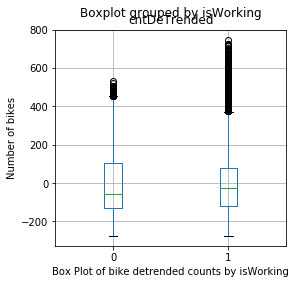

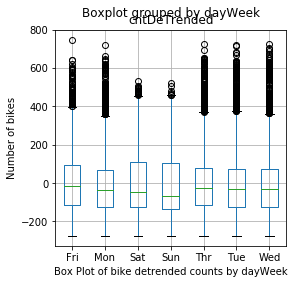

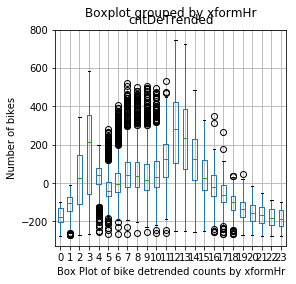

In [16]:
# Task: Complete the statement to include these box plots and in this order: ['hr', 'mnth', 'weathersit', 'isWorking', 'dayWeek', 'xformHr']
colstoBoxPlot = ['hr','mnth','weathersit','isWorking','dayWeek','xformHr']

for cols in colstoBoxPlot:
    fig = plt.figure(figsize=(4,4))
    fig.clf()
    ax = fig.gca()
    bikesData.boxplot(column=['cntDeTrended'], by = [cols], ax = ax)
    plt.xlabel('Box Plot of bike detrended counts by '+str(cols))
    plt.ylabel('Number of bikes')
    plt.show()

#### Scatter Matrix

**Task:** Complete the statements to plot the scatter matrix for these columns: ['temp', 'hum', 'windspeed', 'hr', 'xformHr', 'cntDeTrended']

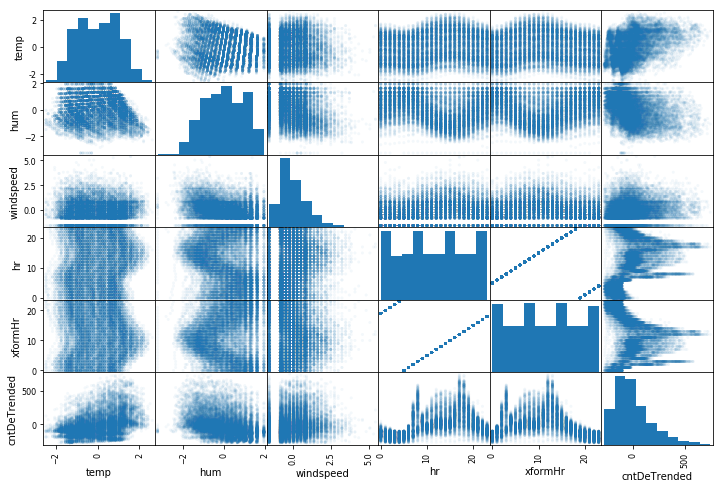

In [17]:
# Task: Complete the statements to plot the scatter matrix for these columns: ['temp', 'hum', 'windspeed', 'hr', 'xformHr', 'cntDeTrended']
columnToPlotScatter = ['temp','hum','windspeed','hr','xformHr','cntDeTrended']
from pandas.plotting import scatter_matrix
scatter_matrix(bikesData[columnToPlotScatter], figsize=(12,8), alpha=0.05)
plt.show()

#### Plotting box plots for 0900 and 1800 hrs working and non-working days

Contrary to the previous observation. there is perhaps an interaction between the time of day of working and nonworking days. A day of week effect is not apparent, but we may need to look in more detail. This idea is easy to explore. 

**Task:** Adding the following code creates box plots for peak demand hours of working and nonworking days. Complete the code to box plot the bike counts for isWorking - [0,1] for these hours: [0900, 1800]

C:\Users\Pratik\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


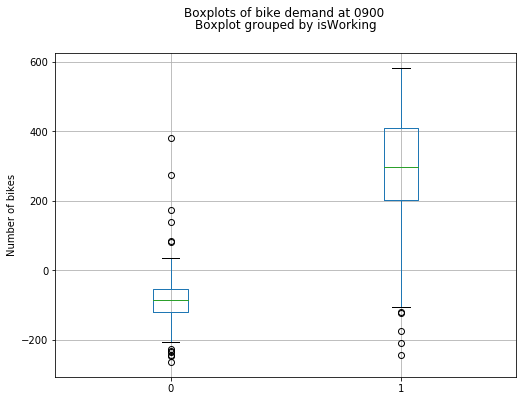

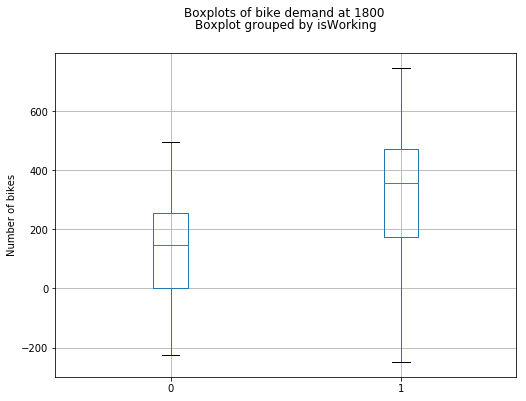

In [18]:
labels = ["Boxplots of bike demand at 0900 \n\n", "Boxplots of bike demand at 1800 \n\n"]
times = [8, 17]
# Task: Complete these statements
col = ['cntDeTrended']
byCol = ['isWorking']
for lab, tms in zip(labels, times):
    temp = bikesData[bikesData.hr == tms]
    fig = plt.figure(figsize=(8, 6))
    fig.clf()
    ax = fig.gca()
    
    temp.boxplot(column = col, by = byCol, ax = ax)
    plt.xlabel('')
    plt.ylabel('Number of bikes')
    plt.title(lab)
    plt.show()

#### Plotting Transformed Work hours versus the count

In accordance with our previous observation, we shall plot the demand counts for each of the transformed work hours which includes working and non-working hours.

**Task**: Complete the statement to plot detrended count and the xformWorkHr.

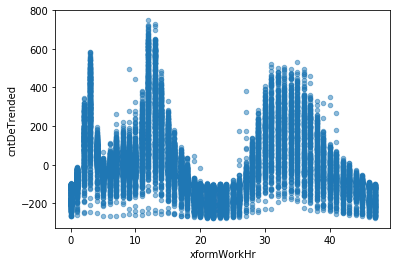

In [19]:
# Task
x_plot = 'xformWorkHr'
y_plot = 'cntDeTrended'
ax = fig.gca()
bikesData.plot(kind='scatter', x = x_plot, y = y_plot, alpha = 0.5)
plt.show()

### Dividing the dataset into training and test dataset

After having analyzed the dataset, we shall divide the entire dataset into training and test set using train_test_split in the ratio 70:30 It uses random sorting and hence the resulting train_set and test_set is sorted by daycount.

**Task:** Correct the train_test_split function to split the test set in the ratio 70:30.
		from sklearn.model_selection import train_test_split

In [20]:
from sklearn.model_selection import train_test_split
# Task: Correct the train_test_split function to split the test set in the ratio 70:30
train_set, test_set = train_test_split(bikesData, test_size=0.3, random_state=42)
train_set.sort_values('dayCount', axis= 0, inplace=True)
test_set.sort_values('dayCount', axis= 0, inplace=True)
print(len(train_set), "train +", len(test_set), "test")

12165 train + 5214 test


C:\Users\Pratik\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Pratik\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### Training and analyze models

Models to be trained and analyzed: 
1. DecisionTreeRegressor
1. LinearRegression 
1. RandomForestRegressor

Metrics calculated: neg_mean_absolute_error, neg_mean_squared_error using cross-validation

**Task 1:** Complete the statement to define forest_reg as a RandomForestRegressor with random_state = 42

**Task 2:** Store predicted values from the classifier using cross_val_predict. As identified as action tasks Consider 'xformHr', 'xformWorkHr','temp' as the training features and 10 folds.

Features used:
1. xformWorkHr
1. temp
1. dayCount

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [22]:
trainingCols = train_set[['xformWorkHr','temp','dayCount']]
trainingLabels = train_set['cnt']

# Train a Decision Tree Regressor
rfc_clf = DecisionTreeRegressor(random_state = 42)
display_scores(-cross_val_score(rfc_clf, trainingCols, trainingLabels, cv=10, scoring="neg_mean_absolute_error"))
display_scores(np.sqrt(-cross_val_score(rfc_clf, trainingCols, trainingLabels, cv=10, scoring="neg_mean_squared_error")))
train_set_dtr = train_set.copy()
train_set_dtr['predictedCounts'] = cross_val_predict(rfc_clf, trainingCols, trainingLabels, cv=10)
train_set_dtr['resids'] = train_set_dtr['predictedCounts'] - trainingLabels

Scores: [  29.45193098   48.53492194   37.08792112   54.01643385   54.19884963
   57.67269737   64.68421053   63.81496711   55.515625    100.24917763]
Mean: 56.522673515
Standard deviation: 17.9447829973
Scores: [  45.99933014   74.54911304   58.79207265   88.94009321   86.89883993
   90.38307546  106.69837282  100.49566713   92.58770291  154.48475216]
Mean: 89.982901945
Standard deviation: 27.7733364165


In [23]:
# Train a Linear Regression model
lin_reg = LinearRegression()
display_scores(-cross_val_score(lin_reg, trainingCols, trainingLabels, cv=10, scoring="neg_mean_absolute_error"))
display_scores(np.sqrt(-cross_val_score(lin_reg, trainingCols, trainingLabels, cv=10, scoring="neg_mean_squared_error")))
train_set_lin = train_set.copy()
train_set_lin['predictedCounts'] = cross_val_predict(rfc_clf, trainingCols, trainingLabels, cv=10)
train_set_lin['resids'] = train_set_lin['predictedCounts'] - trainingLabels

Scores: [  62.29527472   90.60871832  134.99710104  120.7050177    87.65203691
   95.09526459  153.68788949  177.0099255   183.21306065  137.61263548]
Mean: 124.287692442
Standard deviation: 38.2007693833
Scores: [  79.02462583  119.71270616  154.46146441  143.1340909   110.38911514
  129.89481215  198.27301911  210.5833168   229.90475061  176.62358571]
Mean: 155.200148683
Standard deviation: 45.6277346881


In [24]:
# Let's train one more model using Random Forests
# Task 1: make changes here
forest_reg = RandomForestRegressor(n_estimators=40, random_state=42)

# Task 2: Is everything ok here?
display_scores(-cross_val_score(forest_reg, trainingCols, trainingLabels, cv=10, scoring="neg_mean_absolute_error"))
display_scores(np.sqrt(-cross_val_score(forest_reg, trainingCols, trainingLabels, cv=10, scoring="neg_mean_squared_error")))
train_set_freg = train_set.copy()
train_set_freg['predictedCounts'] = cross_val_predict(forest_reg, train_set[['xformWorkHr','temp','dayCount']], trainingLabels, cv=10)
train_set_freg['resids'] = train_set_freg['predictedCounts'] - trainingLabels

Scores: [ 26.00821693  37.46778965  32.12635579  43.14568611  43.30051356
  48.09660773  55.81196546  52.84169408  47.65534539  73.28499178]
Mean: 45.9739166479
Standard deviation: 12.5501621169
Scores: [  41.22418921   58.93237107   49.67591696   69.93859037   70.64134217
   76.66341897   90.19290757   80.82505912   80.13285032  112.11651666]
Mean: 73.0343162422
Standard deviation: 19.2815056291


### Visualizing prediction versus actual values

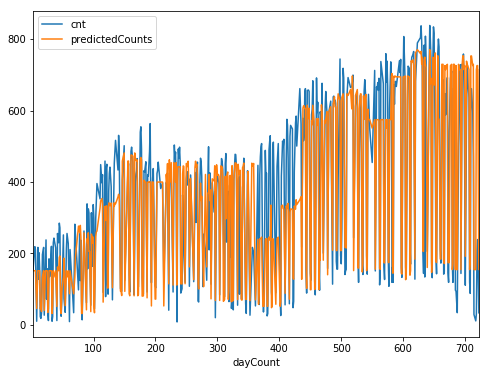

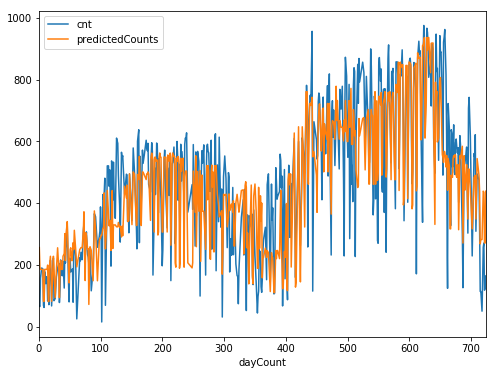

In [25]:
# Just to plot, try to add more details to the plots

times = [8,17]
for time in times:
    fig = plt.figure(figsize=(8, 6))
    fig.clf()
    ax = fig.gca()
    train_set_freg_time = train_set_freg[train_set.hr == time]
    train_set_freg_time.plot(kind = 'line', x = 'dayCount', y = 'cnt', ax = ax)
    train_set_freg_time.plot(kind = 'line', x = 'dayCount', y = 'predictedCounts', ax =ax)
    plt.show()

### Fine-tuning the model

**Task 1:** Assign different combination of max_dept and min_samples_leaf and min_samples_split to param_grid - 'max_depth': [28, 30, 32, 34, 36], 'min_samples_leaf': [5, 10, 15, 12],'min_samples_split': [120, 128, 136]

**Task 2:** Calculate the best parameter using GridSearchCV and store it in grid_search. Print the parameters. 
		from sklearn.model_selection import GridSearchCV

**Task 3:** Fit the training dataset to the calculated best parameter model using the fit() method.

**Task 4:** Complete the code to calculate the importance score for each of the feature.

In [26]:
from sklearn.model_selection import GridSearchCV

# Task 1
param_grid = [
    {'max_depth': [28, 30, 32, 34, 36], 'min_samples_leaf': [5, 10, 15, 12],'min_samples_split': [120, 128, 136]},
]

# Task 2
grid_search = GridSearchCV(rfc_clf, param_grid, cv=5, scoring='neg_mean_squared_error')

# Task 3
grid_search.fit(trainingCols, trainingLabels)
print(grid_search.best_params_)

# See the importance score of each attribute in GridSearchCV
# Task 4
feature_importances = grid_search.best_estimator_.feature_importances_
print(feature_importances)

{'max_depth': 28, 'min_samples_leaf': 12, 'min_samples_split': 120}
[ 0.71508045  0.11661388  0.16830567]


In [27]:
# Ignore
#extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"]
#cat_one_hot_attribs = list(cat_encoder.categories_[0])
#attributes = num_attribs + extra_attribs + cat_one_hot_attribs
#sorted(zip(feature_importances, attributes), reverse=True)
feature_importances

array([ 0.71508045,  0.11661388,  0.16830567])

### Evaluate the model on test dataset

**Task 1:** Extract the relevant data from test_set and store it in X_test
		
**Task 2:** Extract the relevant data from test_set and store it in y_test

**Task 3:** Calculate the predicted values from the model and store it in 'predictedCounts_test' 

**Task 4:** Calculate the mean squared error using mean_squared_error function.

In [28]:
final_model = grid_search.best_estimator_

test_set.sort_values('dayCount', axis= 0, inplace=True)

# Task 1: Complete the statement below to extract relevant columns from the test dataset
test_x_cols = ['xformWorkHr', 'temp','dayCount']

# Task 2: Complete the statement below to extract relevant label from test set
test_y_cols = 'cnt'

X_test = test_set.loc[:,test_x_cols]
y_test = test_set.loc[:,test_y_cols]

# Task 3: Calculate the predicted values from the model and store it in 'predictedCounts_test'
test_set.loc[:,'predictedCounts_test'] = final_model.predict(X_test)

# Task 4: Calculate the mean squared error using mean_squared_error function.
final_mse = mean_squared_error(y_test, test_set.loc[:,'predictedCounts_test'])
print(np.sqrt(final_mse))
test_set.describe()

62.1867326606


C:\Users\Pratik\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Pratik\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Pratik\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,isWorking,monthCount,xformHr,dayCount,xformWorkHr,cntDeTrended,predictedCounts_test
count,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000,5214.000000
mean,2.481204,0.504411,6.480437,11.471423,0.030687,3.001534,0.685846,1.422133,-0.012980,-0.002944,0.012217,185.322785,0.685846,12.533372,11.415036,360.850898,18.954737,-3.852672,186.253915
std,1.110062,0.500028,3.457991,6.887845,0.172484,1.995486,0.464223,0.637995,0.993567,0.995428,1.006002,177.755171,0.464223,6.843005,6.909181,207.769276,13.057057,171.964728,167.254476
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-2.477205,-3.251166,-1.553889,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-274.491766,2.168831
25%,1.000000,0.000000,3.000000,6.000000,0.000000,1.000000,0.000000,1.000000,-0.815304,-0.763143,-0.699689,41.000000,0.000000,7.000000,5.000000,180.781250,8.000000,-124.743847,50.210526
50%,2.000000,1.000000,6.000000,11.000000,0.000000,3.000000,1.000000,1.000000,0.015647,0.014364,0.031899,136.000000,1.000000,13.000000,11.000000,362.375000,17.000000,-37.980680,142.560345
75%,3.000000,1.000000,9.000000,17.000000,0.000000,5.000000,1.000000,2.000000,0.742729,0.791871,0.519896,277.000000,1.000000,18.000000,17.000000,537.104167,28.000000,81.281369,277.350515
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,2.404630,1.932215,5.399871,977.000000,1.000000,24.000000,23.000000,724.041667,47.000000,726.303828,832.485294


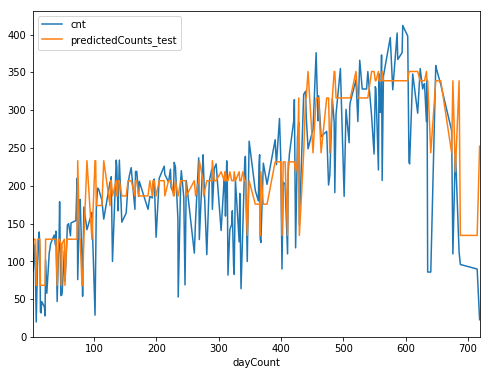

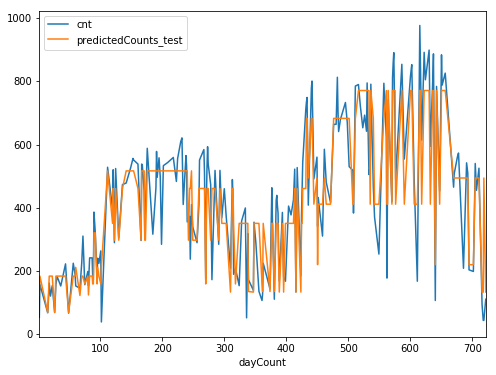

In [29]:
times = [9,18]
for time in times:
    fig = plt.figure(figsize=(8, 6))
    fig.clf()
    ax = fig.gca()
    test_set_freg_time = test_set[test_set.hr == time]
    test_set_freg_time.plot(kind = 'line', x = 'dayCount', y = 'cnt', ax = ax)
    test_set_freg_time.plot(kind = 'line', x = 'dayCount', y = 'predictedCounts_test', ax =ax)
    plt.show()

### Analyzing the residuals
Analyzing the difference between the actual and the calculated values

Plotting the histogram for the observed difference

C:\Users\Pratik\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


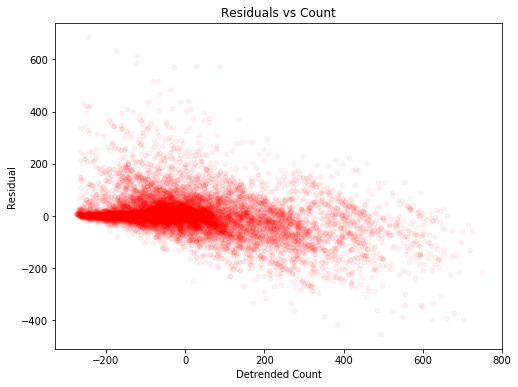

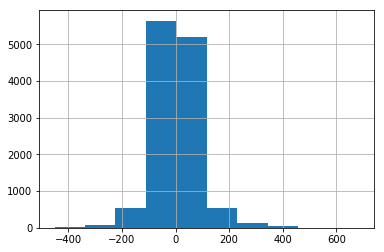

In [30]:
import statsmodels.api as sm

## Plot the residuals vs the label, the count of rented bikes.
fig = plt.figure(figsize=(8, 6))
fig.clf()
ax = fig.gca()
train_set_freg.plot(kind = 'scatter', x = 'cntDeTrended', y = 'resids', alpha = 0.05, color = 'red', ax = ax)
plt.xlabel("Detrended Count")
plt.ylabel("Residual")
plt.title("Residuals vs Count")
plt.show()
## Plotting the resilduals
train_set_freg['resids'].hist()
plt.show()

In [31]:
train_set_freg.boxplot(column = ['resids'], by = ['hr'], ax = ax)
plt.show()

C:\Users\Pratik\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


C:\Users\Pratik\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


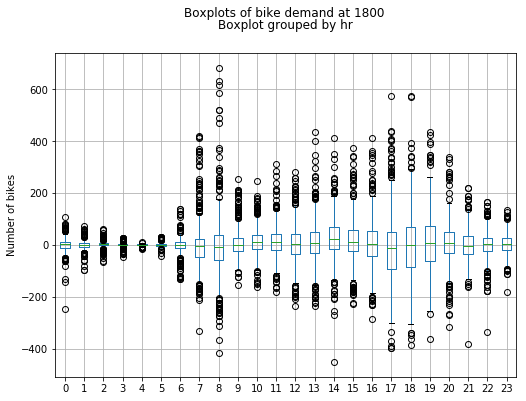

In [32]:
fig = plt.figure(figsize=(8, 6))
fig.clf()
ax = fig.gca()
train_set_freg.boxplot(column = ['resids'], by = ['hr'], ax = ax)
plt.xlabel('')
plt.ylabel('Number of bikes')
plt.title(lab)
plt.show()

C:\Users\Pratik\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


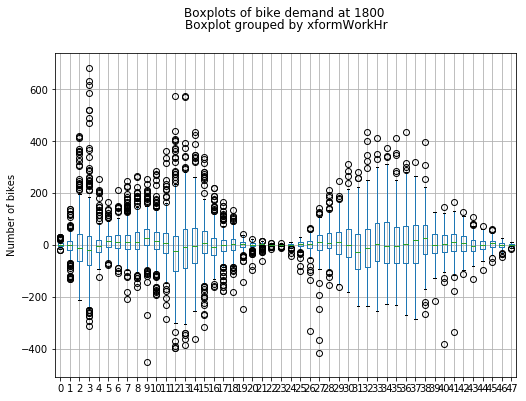

In [33]:
fig = plt.figure(figsize=(8, 6))
fig.clf()
ax = fig.gca()
train_set_freg.boxplot(column = ['resids'], by = ['xformWorkHr'], ax = ax)
plt.xlabel('')
plt.ylabel('Number of bikes')
plt.title(lab)
plt.show()

### Building a Transformation Pipeline

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [35]:
columnsToDrop = ['instant','casual','registered','atemp','dteday']
bikesData = bikesData.drop(columnsToDrop,1)

bikesData['isWorking'] = np.where(np.logical_and(bikesData.workingday==1,bikesData.holiday==0),1,0)
bikesData['monthCount'] = mnth_cnt(bikesData)
bikesData['xformHr'] = np.where(bikesData.hr>4,bikesData.hr-5,bikesData.hr+19)
bikesData['dayCount'] = pd.Series(range(bikesData.shape[0]))/24
bikesData['xformWorkHr'] = bikesData.isWorking*24 + bikesData.xformHr
bikesData = set_day(bikesData)
bikesData.describe()

columnsToScale = ['temp','hum','windspeed']
scaler = StandardScaler()
bikesData[columnsToScale] = scaler.fit_transform(bikesData[columnsToScale])
arry = bikesData[columnsToScale].as_matrix()
bikesData[columnsToScale] = preprocessing.scale(arry)



ValueError: labels ['instant' 'casual' 'registered' 'atemp' 'dteday'] not contained in axis

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        isWorking = np.where(np.logical_and(X.loc[:,'workingday']==1,X.loc[:,'holiday']==0),1,0)
        xformHr = np.where(X.loc[:,'hr']>4,X.loc[:,'hr']-5,X.loc[:,'hr']+19)
        xformWorkHr = isWorking*24 + xformHr
        return np.c_[X, isWorking, xformHr, xformWorkHr]

In [37]:
attr_adder = CombinedAttributesAdder()
bikesData1 = attr_adder.transform(bikesData)
bikesData = pd.DataFrame(bikesData1, columns=list(bikesData.columns)+["isWorking", "xformHr", "xformWorkHr"])
bikesData.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,...,isWorking,monthCount,xformHr,dayCount,xformWorkHr,dayWeek,cntDeTrended,isWorking,xformHr,xformWorkHr
0,1,0,1,0,0,6,0,1,-1.33465,0.947372,...,0,1,19,0,43,Sat,-86.0117,0,19,19
1,1,0,1,1,0,6,0,1,-1.43852,0.895539,...,0,1,20,0.0416667,44,Sat,-62.0218,0,20,20
2,1,0,1,2,0,6,0,1,-1.43852,0.895539,...,0,1,21,0.0833333,45,Sat,-70.0318,0,21,21
3,1,0,1,3,0,6,0,1,-1.33465,0.63637,...,0,1,22,0.125,46,Sat,-89.0419,0,22,22
4,1,0,1,4,0,6,0,1,-1.33465,0.63637,...,0,1,23,0.166667,47,Sat,-101.052,0,23,23
